In [ ]:
import graphviz
from IPython.display import HTML
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import numpy as np
import os
import pandas as pd
from scipy.interpolate import interp1d
from scipy.signal import savgol_filter
import seaborn as sns
from sklearn.cluster import DBSCAN, KMeans
from sklearn.decomposition import PCA
from sklearn.ensemble import HistGradientBoostingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, mean_squared_error, recall_score, roc_auc_score, roc_curve, silhouette_score
from sklearn.model_selection import cross_val_score, GridSearchCV, StratifiedKFold, train_test_split
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler
from sklearn.tree import export_graphviz, DecisionTreeClassifier
import time
from xgboost import XGBClassifier
SEED = 42

# Exploratory Data Analysis

,PatientID,Age,Gender,Ethnicity,EducationLevel,BMI,Smoking,AlcoholConsumption,PhysicalActivity,DietQuality,...,MemoryComplaints,BehavioralProblems,ADL,Confusion,Disorientation,PersonalityChanges,DifficultyCompletingTasks,Forgetfulness,Diagnosis,DoctorInCharge
0,4751,73,0,0,2,22.927749,0,13.297218,6.327112,1.347214,...,0,0,1.725883,0,0,0,1,0,0,XXXConfid
1,4752,89,0,0,0,26.827681,0,4.542524,7.619885,0.518767,...,0,0,2.592424,0,0,0,0,1,0,XXXConfid
2,4753,73,0,3,1,17.795882,0,19.555085,7.844988,1.826335,...,0,0,7.119548,0,1,0,1,0,0,XXXConfid
3,4754,74,1,0,1,33.800817,1,12.209266,8.428001,7.435604,...,0,1,6.481226,0,0,0,0,0,0,XXXConfid
4,4755,89,0,0,0,20.716974,0,18.454356,6.310461,0.795498,...,0,0,0.014691,0,0,1,1,0,0,XXXConfid


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2149 entries, 0 to 2148
Data columns (total 35 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   PatientID                  2149 non-null   int64  
 1   Age                        2149 non-null   int64  
 2   Gender                     2149 non-null   int64  
 3   Ethnicity                  2149 non-null   int64  
 4   EducationLevel             2149 non-null   int64  
 5   BMI                        2149 non-null   float64
 6   Smoking                    2149 non-null   int64  
 7   AlcoholConsumption         2149 non-null   float64
 8   PhysicalActivity           2149 non-null   float64
 9   DietQuality                2149 non-null   float64
 10  SleepQuality               2149 non-null   float64
 11  FamilyHistoryAlzheimers    2149 non-null   int64  
 12  CardiovascularDisease      2149 non-null   int64  
 13  Diabetes                   2149 non-null   int64

None

,PatientID,Age,Gender,Ethnicity,EducationLevel,BMI,Smoking,AlcoholConsumption,PhysicalActivity,DietQuality,...,FunctionalAssessment,MemoryComplaints,BehavioralProblems,ADL,Confusion,Disorientation,PersonalityChanges,DifficultyCompletingTasks,Forgetfulness,Diagnosis
count,2149.000000,2149.000000,2149.000000,2149.000000,2149.000000,2149.000000,2149.000000,2149.000000,2149.000000,2149.000000,...,2149.000000,2149.000000,2149.000000,2149.000000,2149.000000,2149.000000,2149.000000,2149.000000,2149.000000,2149.000000
mean,5825.000000,74.908795,0.506282,0.697534,1.286645,27.655697,0.288506,10.039442,4.920202,4.993138,...,5.080055,0.208004,0.156817,4.982958,0.205212,0.158213,0.150768,0.158678,0.301536,0.353653
std,620.507185,8.990221,0.500077,0.996128,0.904527,7.217438,0.453173,5.757910,2.857191,2.909055,...,2.892743,0.405974,0.363713,2.949775,0.403950,0.365026,0.357906,0.365461,0.459032,0.478214
min,4751.000000,60.000000,0.000000,0.000000,0.000000,15.008851,0.000000,0.002003,0.003616,0.009385,...,0.000460,0.000000,0.000000,0.001288,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,5288.000000,67.000000,0.000000,0.000000,1.000000,21.611408,0.000000,5.139810,2.570626,2.458455,...,2.566281,0.000000,0.000000,2.342836,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,5825.000000,75.000000,1.000000,0.000000,1.000000,27.823924,0.000000,9.934412,4.766424,5.076087,...,5.094439,0.000000,0.000000,5.038973,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,6362.000000,83.000000,1.000000,1.000000,2.000000,33.869778,1.000000,15.157931,7.427899,7.558625,...,7.546981,0.000000,0.000000,7.581490,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000
max,6899.000000,90.000000,1.000000,3.000000,3.000000,39.992767,1.000000,19.989293,9.987429,9.998346,...,9.996467,1.000000,1.000000,9.999747,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


                           PatientID       Age    Gender  Ethnicity  \
PatientID                   1.000000  0.002947 -0.043665  -0.007608   
Age                         0.002947  1.000000  0.028708   0.027745   
Gender                     -0.043665  0.028708  1.000000  -0.003660   
Ethnicity                  -0.007608  0.027745 -0.003660   1.000000   
EducationLevel             -0.001729 -0.060560 -0.007070   0.026516   
BMI                        -0.034228 -0.015677  0.005928  -0.003176   
Smoking                     0.021907  0.020060  0.016650   0.031485   
AlcoholConsumption         -0.020733  0.007323  0.004330   0.008363   
PhysicalActivity           -0.011424 -0.010249 -0.035795   0.020498   
DietQuality                -0.018490 -0.023386  0.010942  -0.018184   
SleepQuality               -0.026069  0.049139  0.007310   0.029304   
FamilyHistoryAlzheimers     0.002187 -0.018784  0.018421   0.022526   
CardiovascularDisease       0.017675 -0.015284  0.034577   0.002347   
Diabet

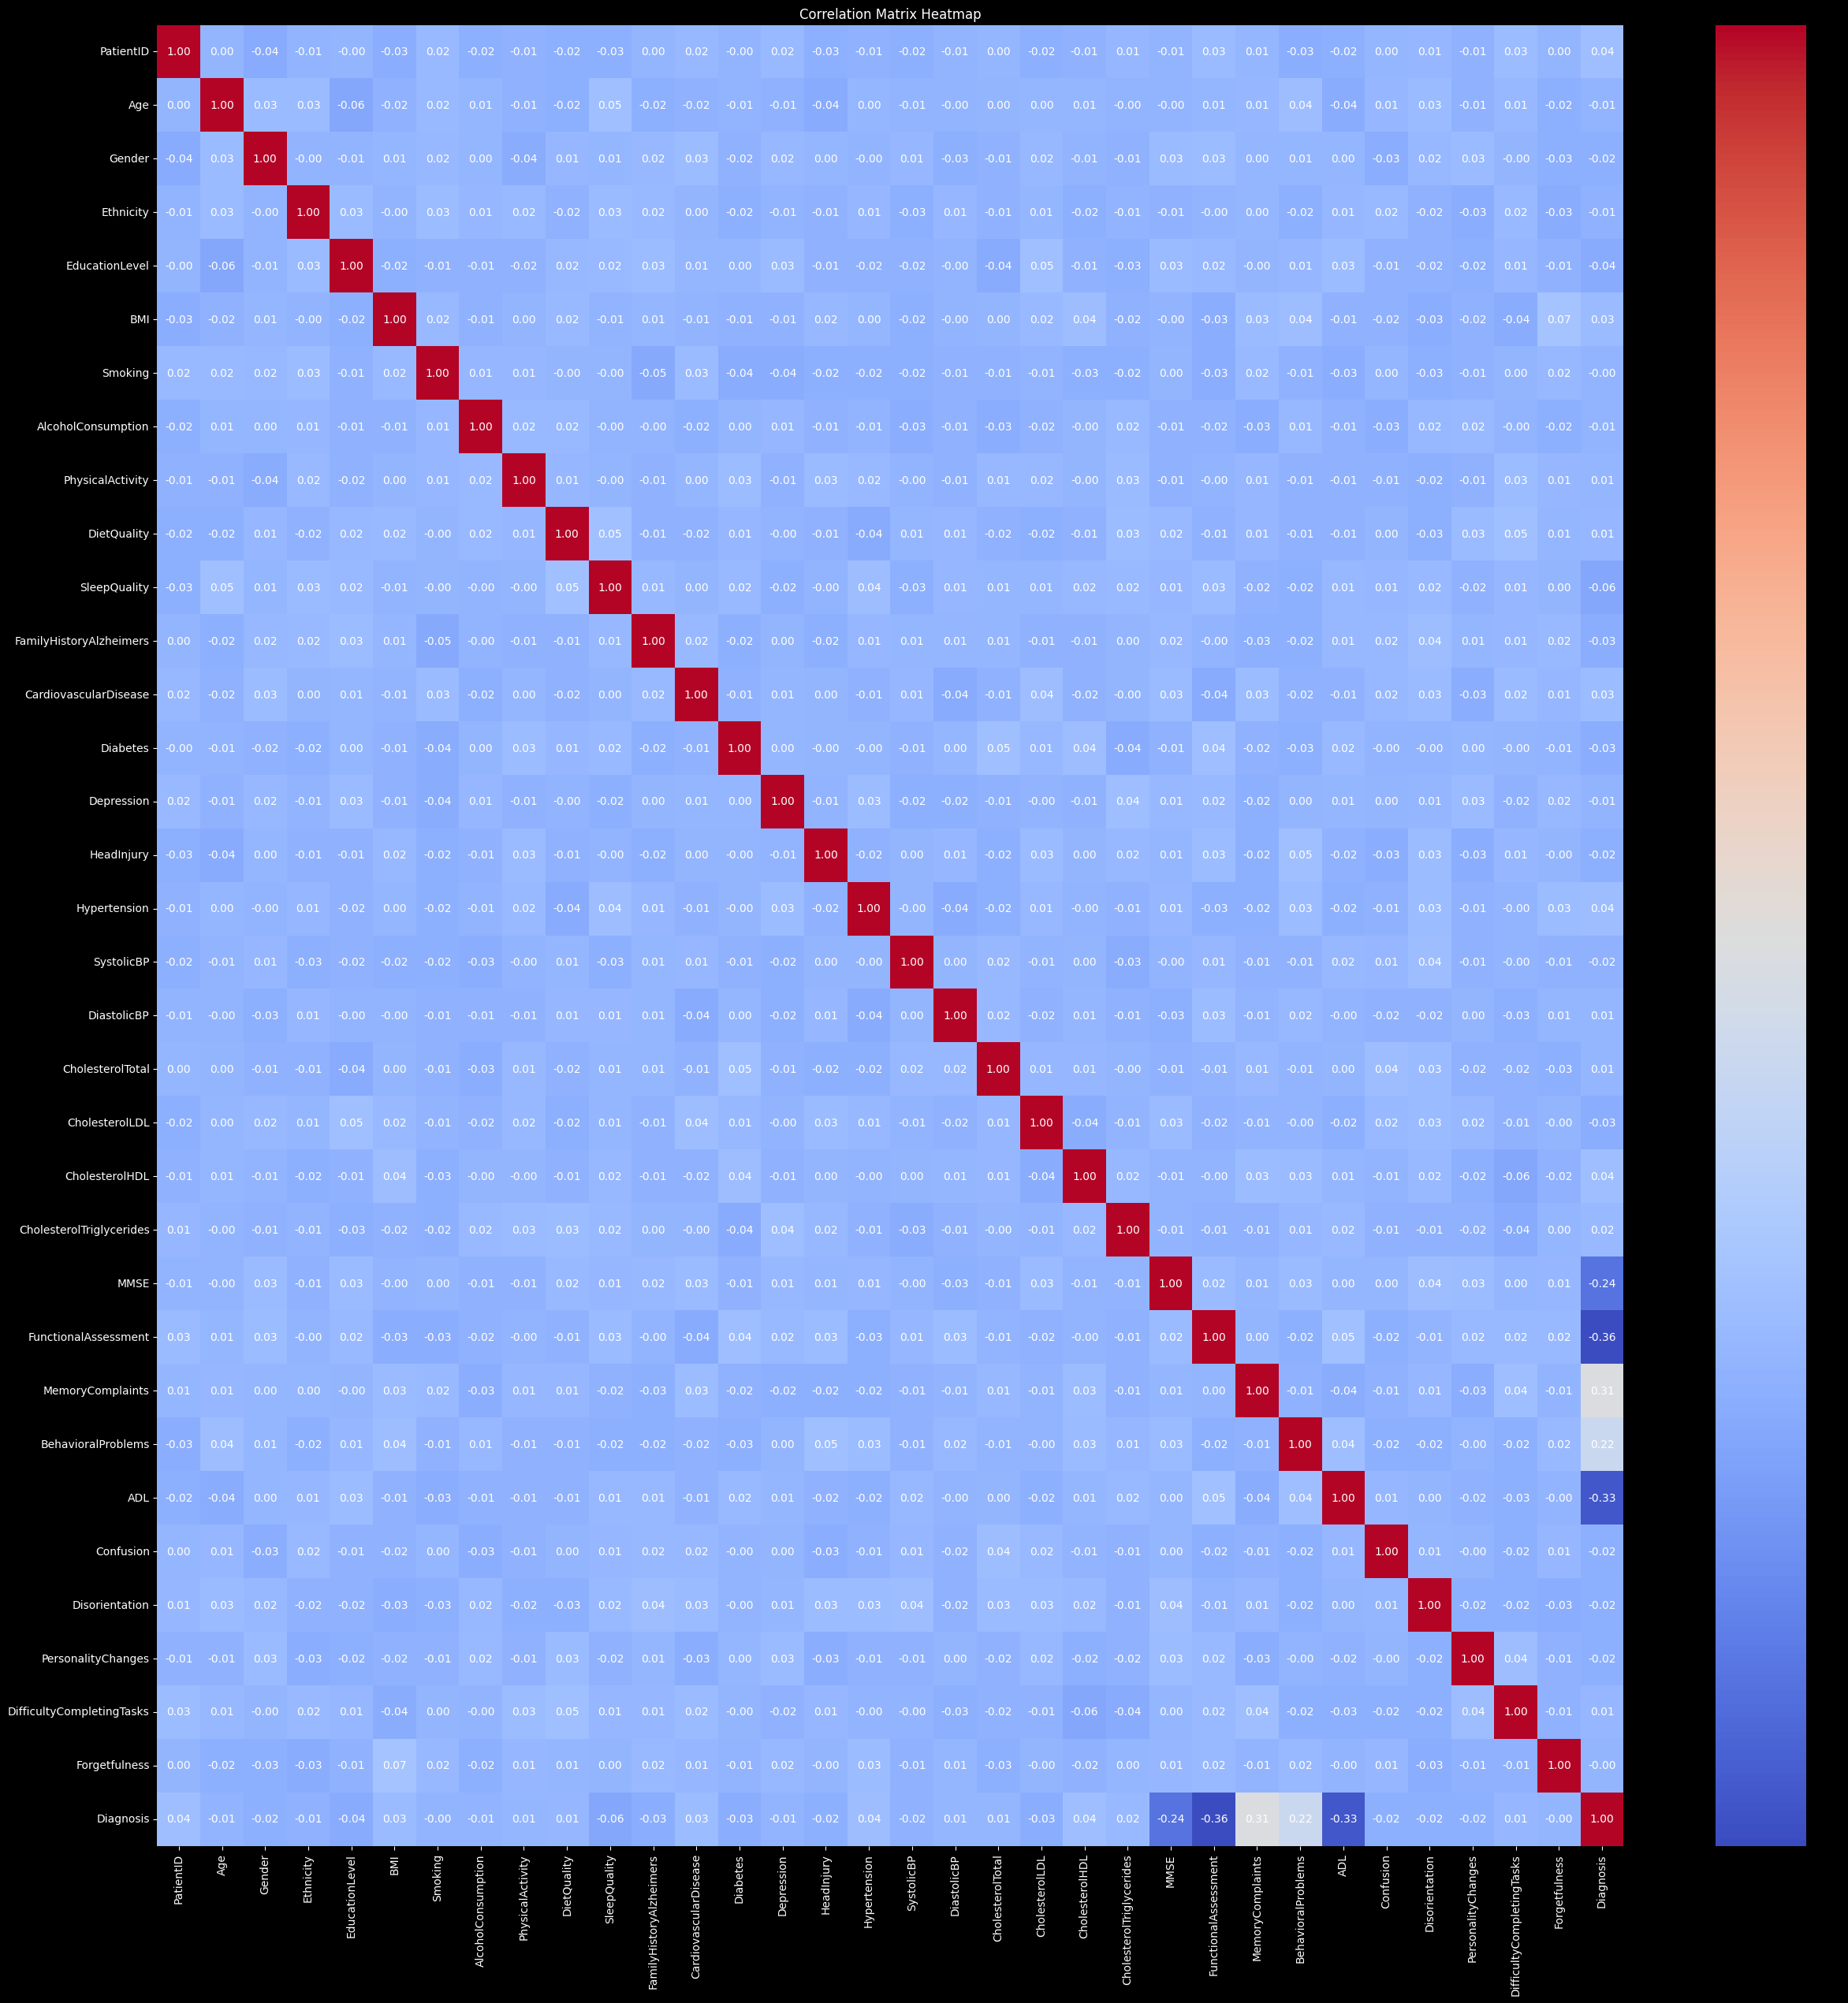

In [4]:
#Accessing original dataset
os.chdir('..')
NeuroCurveOG = pd.read_csv("CSV/alzheimers_disease_data.csv")
os.chdir('NeuroPy')

#Displaying some facts about the dataset
display(NeuroCurveOG.head())
display(NeuroCurveOG.info())
display(NeuroCurveOG.describe()) #Look at dataframe

#Plotting a Correlation Matrix
NeuroCurveOG_numeric = NeuroCurveOG.select_dtypes(include=['number'])
corr_matrix = NeuroCurveOG_numeric.corr() #create correlation matrix 
print(corr_matrix)
plt.figure(figsize=(30, 30), facecolor='black')
plt.title("Correlation Matrix Heatmap", color="white")
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', annot_kws={"color": "white"})

ax = plt.gca()

for spine in ax.spines.values():
    spine.set_linewidth(2.5) 
    spine.set_color('white')

    ax.tick_params(axis='x', colors='white')
    ax.tick_params(axis='y', colors='white')

plt.show()

## Processing

In [5]:
os.chdir('..')
#Drops any unnecessary features of the original dataset
usableCSV = NeuroCurveOG.drop(columns=["PatientID", "Diabetes", "CardiovascularDisease", "DoctorInCharge", "Depression", "SystolicBP", "DiastolicBP"])
usableCSV.to_csv('CSV/output_CSVs/processed.csv',index=False)

os.chdir('NeuroPy')     

#Creating X and Y features for models
X = usableCSV.drop(columns=['Diagnosis'])
y = usableCSV['Diagnosis']

#One-Hot encoding categorical data
categorical_cols = ['Gender', 'Ethnicity', 'FamilyHistoryAlzheimers']
X[categorical_cols] = X[categorical_cols].astype('category')
X = pd.get_dummies(X, drop_first=True)  # One-hot encoding

#Scaling features via z-score normalization
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

## Model Test Split


In [6]:
#Splitting scaled dataset into training and testing datasets
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=SEED, stratify=y
)

## Training

In [ ]:
results = {}

''' ----------- Logistic Model Training ----------- '''
log = LogisticRegression(class_weight='balanced', max_iter=1000, penalty='l2', C=1.0, solver='liblinear')
log.fit(X_train, y_train)
results['LogisticRegression'] = {'model':log,
                                 'accuracy':accuracy_score(y_test, log.predict(X_test)), 
                                 'y_prob':log.predict_proba(X_test), 
                                 'y_pred':log.predict(X_test), 
                                 'y_prob_class1':log.predict_proba(X_test)[:, 1], 
                                 'plot_pos':(0,0,'Logistic Regression'),
                                 'mse': mean_squared_error(y_test, log.predict(X_test))}

'''------------- Decision Tree Model Training ---------'''
tree = DecisionTreeClassifier(random_state=2028, max_depth= 5) # 93.02 = 2028
tree.fit(X_train, y_train)
results['DecisionTree'] = {'model':tree,
                           'accuracy':accuracy_score(y_test, tree.predict(X_test)), 
                           'y_prob':tree.predict_proba(X_test), 
                           'y_pred':tree.predict(X_test), 
                           'y_prob_class1':tree.predict_proba(X_test)[:, 1], 
                           'plot_pos':(0,1,'Decision Tree'),
                           'mse': mean_squared_error(y_test, tree.predict(X_test))}

'''------------ Random Forest Model Training---------'''
forest = RandomForestClassifier(max_features='sqrt', n_estimators=len(X_train), random_state=SEED, max_depth=14) # 95.12 at md = 14
forest.fit(X_train, y_train)
results['RandomForest'] = {'model':forest,
                           'accuracy':accuracy_score(y_test, forest.predict(X_test)), 
                           'y_prob':forest.predict_proba(X_test), 
                           'y_pred':forest.predict(X_test), 
                           'y_prob_class1':forest.predict_proba(X_test)[:, 1], 
                           'plot_pos':(0,2,'Random Forest'),
                            'mse': mean_squared_error(y_test, forest.predict(X_test))}

'''----------------Hist Gradient Boost Training--------'''
histGradient = HistGradientBoostingClassifier(l2_regularization= 0, learning_rate= 0.1, max_depth= 3, max_iter= 100)
histGradient.fit(X_train, y_train)
results['HistGradientBoost'] = {'model':histGradient,
                                'accuracy':accuracy_score(y_test, histGradient.predict(X_test)), 
                                'y_prob':histGradient.predict_proba(X_test), 
                                'y_pred':histGradient.predict(X_test), 
                                'y_prob_class1':histGradient.predict_proba(X_test)[:, 1], 
                                'plot_pos':(1,0,'Hist Gradient Boost'),
                                 'mse': mean_squared_error(y_test, histGradient.predict(X_test))}

'''----------------XG Boost Training-------------------------'''
xgBoost = XGBClassifier(colsample_bytree=0.8, learning_rate=0.1, max_depth=3, n_estimators=50, subsample=1.0)
xgBoost.fit(X_train, y_train)
results['XGBoost'] = {'model':xgBoost,
                      'accuracy':accuracy_score(y_test, xgBoost.predict(X_test)), 
                      'y_prob':xgBoost.predict_proba(X_test), 
                      'y_pred':xgBoost.predict(X_test), 
                      'y_prob_class1':xgBoost.predict_proba(X_test)[:, 1], 
                      'plot_pos':(1,1,'XGBoost'),
                      'mse': mean_squared_error(y_test, xgBoost.predict(X_test))}

for model_name, metrics in results.items():
    print(f"{model_name}: \n        Accuracy: {metrics['accuracy'] * 100:.2f}%\n        MSE: {metrics['mse']}")

LogisticRegression: 
        Accuracy: 81.40%
        MSE: 0.18604651162790697
DecisionTree: 
        Accuracy: 93.49%
        MSE: 0.06511627906976744
RandomForest: 
        Accuracy: 95.12%
        MSE: 0.04883720930232558
HistGradientBoost: 
        Accuracy: 95.58%
        MSE: 0.044186046511627906
XGBoost: 
        Accuracy: 95.35%
        MSE: 0.046511627906976744


Predicted probabilities for the first 5 examples:
 [[0.16827834 0.83172166]
 [0.84565866 0.15434134]
 [0.23991351 0.76008649]
 [0.52365979 0.47634021]
 [0.08809886 0.91190114]]
y_pred: [1 0 1 0 1]
y_test: [1 1 1 1 1]
Accuracy: 95.12%
FunctionalAssessment         0.191298
ADL                          0.175009
MMSE                         0.128262
MemoryComplaints             0.096049
BehavioralProblems           0.050802
DietQuality                  0.032843
CholesterolTriglycerides     0.031827
BMI                          0.031682
CholesterolHDL               0.031638
PhysicalActivity             0.031148
SleepQuality                 0.030419
CholesterolTotal             0.029918
AlcoholConsumption           0.029676
CholesterolLDL               0.028911
Age                          0.024397
EducationLevel               0.010656
Ethnicity_1                  0.004468
Gender_1                     0.004152
Forgetfulness                0.003990
Ethnicity_2                  0.003955
Smokin

/var/folders/j2/cbd2g1ts41q3ty9mx613wqsw0000gn/T/ipykernel_44864/2558732792.py:39: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


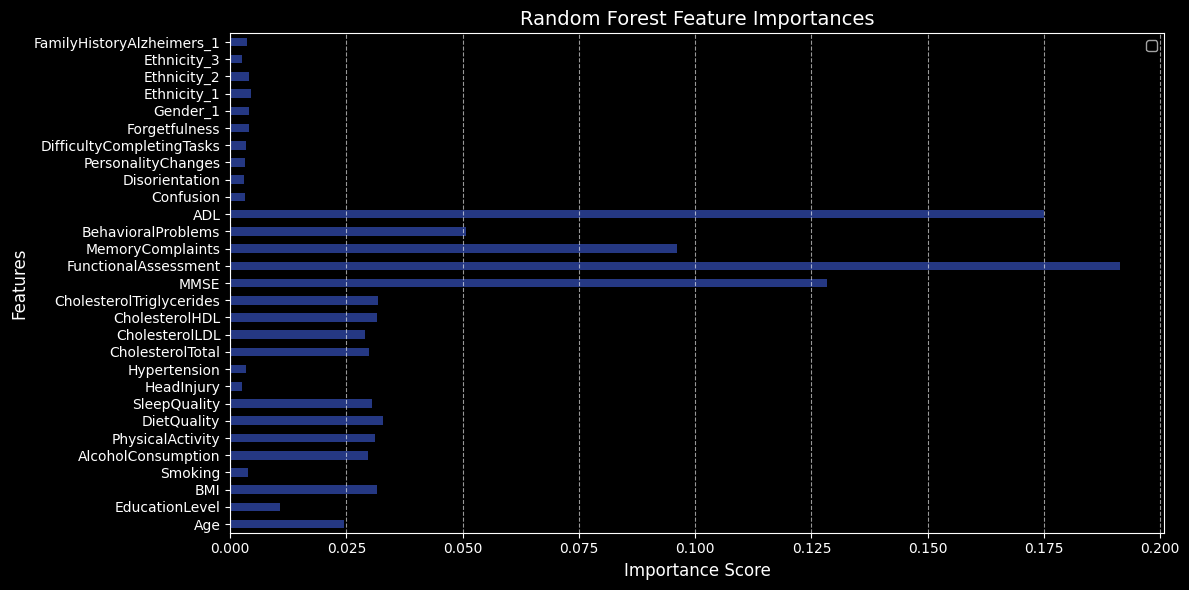

In [9]:
''' ----------- Evaluation ----------- '''
y_prob_forest = forest.predict_proba(X_test)
print("Predicted probabilities for the first 5 examples:\n", y_prob_forest[:5])
y_pred_forest = forest.predict(X_test)
print(f"y_pred: {y_pred_forest[:5]}")
print(f"y_test: {y_test.values[:5]}")
accuracy = accuracy_score(y_test, y_pred_forest)
print(f"Accuracy: {accuracy * 100:.2f}%")

# Assuming `model` is your trained RandomForestClassifier
feature_importances = pd.Series(
   forest.feature_importances_,
   index=X.columns
)

# Sort features by importance (descending)
print(feature_importances.sort_values(ascending=False))

# Get importance of 'Age' specifically
age_importance = feature_importances['Age']
print(f"\nImportance of 'Age': {age_importance:.4f}")
plt.style.use("dark_background")
plt.figure(figsize=(12, 6))

# Plot horizontal bar graph (easier to read long feature names)
feature_importances.plot(kind='barh', color='#253883')

# Highlight the 'Age' feature
'''if 'Age' in feature_importances:
   age_idx = feature_importances.index.get_loc('Age')
   plt.barh(age_idx, feature_importances['Age'], color='red', label='Age')'''

# Customize the plot

plt.title("Random Forest Feature Importances", fontsize=14)
plt.xlabel("Importance Score", fontsize=12)
plt.ylabel("Features", fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
#Defining parameter grids for hyperparamter tuning
param_grids = {
    'LogisticRegression': {'penalty': ['l2'],'C': [0.01, 0.1, 1, 10],'solver': ['liblinear', 'saga']},
    'DecisionTree': {'max_depth': [3, 5, 7, None],'min_samples_split': [2, 5, 10],'min_samples_leaf': [1, 2, 4]},
    'RandomForest': {'n_estimators': [50, 100, 200],'max_depth': [3, 5, 7, None],'min_samples_split': [2, 5],'max_features': ['sqrt', 'log2']},
    'HistGradientBoost': {'learning_rate': [0.01, 0.1, 0.2],'max_iter': [100, 200],'max_depth': [3, 5, 7],'l2_regularization': [0, 0.1]},
    'XGBoost': {'n_estimators': [50, 100, 200],'max_depth': [3, 5, 7],'learning_rate': [0.01, 0.1, 0.2],'subsample': [0.8, 0.9, 1.0]}
}

#Initializing models at a fixed random_state for reproducability
models = {
    'LogisticRegression': LogisticRegression(random_state=SEED),
    'DecisionTree': DecisionTreeClassifier(random_state=SEED),
    'RandomForest': RandomForestClassifier(random_state=SEED),
    'HistGradientBoost': HistGradientBoostingClassifier(random_state=SEED),
    'XGBoost': XGBClassifier(random_state=SEED, eval_metric='logloss')
}

#Dictionaries to store the best model and hyperparameters after tuning
best_models = {}
best_params = {}

#Loop over every model to perform hyperparameter tuning via GridSearchCV
for model_name, model in models.items():
    print(f"\n=== Tuning {model_name} ===")
    start_time = time.time()
    
    #Setting up GridSearchCV object with 5-fold cross validation, accuracy scoring, and parallel jobs to aid in speed
    grid_search = GridSearchCV(estimator=model, param_grid=param_grids[model_name], cv=5, scoring='accuracy', n_jobs=-1)
    grid_search.fit(X_train, y_train)
    
    #Storing model with optimal parameters
    best_models[model_name] = grid_search.best_estimator_
    
    #Storing best parameters
    best_params[model_name] = grid_search.best_params_
    
    # Print out the best parameters and best cross-validation accuracy, as well as the elapsed time for tuning
    print(f"Best parameters: {grid_search.best_params_}")
    print(f"Best CV accuracy: {grid_search.best_score_:.4f}")
    print(f"Time elapsed: {time.time() - start_time:.2f} seconds")

#Printing best models found
print("\n=== Best Models ===")
for model_name, model in best_models.items():
    print(f"{model_name}: {model}")


=== Tuning LogisticRegression ===
Best parameters: {'C': 0.01, 'penalty': 'l2', 'solver': 'saga'}
Best CV accuracy: 0.8429
Time elapsed: 46.98 seconds

=== Tuning DecisionTree ===
Best parameters: {'max_depth': 5, 'min_samples_leaf': 4, 'min_samples_split': 10}
Best CV accuracy: 0.9442
Time elapsed: 2.20 seconds

=== Tuning RandomForest ===
Best parameters: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_split': 5, 'n_estimators': 200}
Best CV accuracy: 0.9436
Time elapsed: 24.69 seconds

=== Tuning HistGradientBoost ===
Best parameters: {'l2_regularization': 0, 'learning_rate': 0.1, 'max_depth': 3, 'max_iter': 100}
Best CV accuracy: 0.9506
Time elapsed: 5.81 seconds

=== Tuning XGBoost ===
Best parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50, 'subsample': 0.8}
Best CV accuracy: 0.9494
Time elapsed: 11.13 seconds

=== Best Models ===
LogisticRegression: LogisticRegression(C=0.01, random_state=42, solver='saga')
DecisionTree: DecisionTreeClassifier(max_de

## Analysis

K-Fold Cross Validation

In [40]:
#Creating a k-fold object with a split of 10 and random_state of SEED for reproducability
kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=SEED)

#Looping through each model in the results dictionary in order to find the k-fold cross validation accuracy
for model_name, metrics in results.items():
    #Speeding up calculations utilizing GPU
    #if model_name == 'XGBoost':
    #    metrics['model'].set_params(tree_method='gpu_hist', gpu_id=0)
    
    #Calculating the k-fold cross validation on the scaled data using accuracy as scoring metric and allowing parallel computation using all available CPU cores
    scores = cross_val_score(metrics['model'], X_scaled, y, cv=kf, scoring='accuracy', n_jobs=-1)
    
    #Calculate the mean accuracy score across every fold
    metrics['cross_val_score_mean'] = scores.mean()
    
    #Storing the score in the results dictionary
    results[model_name]['k-fold'] = metrics["cross_val_score_mean"] * 100
    
    print(f'Cross-validated {model_name} accuracy: {metrics["cross_val_score_mean"] * 100:.2f}%')

Cross-validated LogisticRegression accuracy: 82.74%
Cross-validated DecisionTree accuracy: 94.60%
Cross-validated RandomForest accuracy: 95.21%
Cross-validated HistGradientBoost accuracy: 95.07%
Cross-validated XGBoost accuracy: 95.35%


## Visualization

### Decision Tree Plot

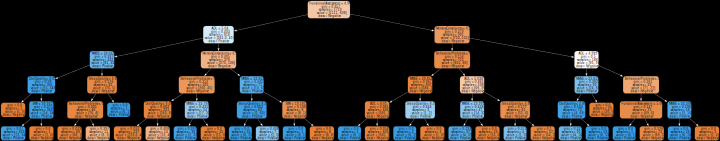

In [52]:
#Export the trained tree into a DOT format for visualization
dot_data = export_graphviz(tree,out_file = None,
                           feature_names=X.columns,
                           class_names=['Negative','Positive'],
                           filled=True, rounded=True,
                           special_characters=True)

#Customize the DOT data string to change graph appearance.
dot_data = 'digraph Tree {\nsize="10,10";\nbgcolor="black";\nedge [color="white"];\n' + '\n'.join(dot_data.split('\n')[1:])

#Create a graphiz source object from the modified DOT
d_tree_Comprehensible = graphviz.Source(dot_data)
display(d_tree_Comprehensible)

### Confusion Matrices

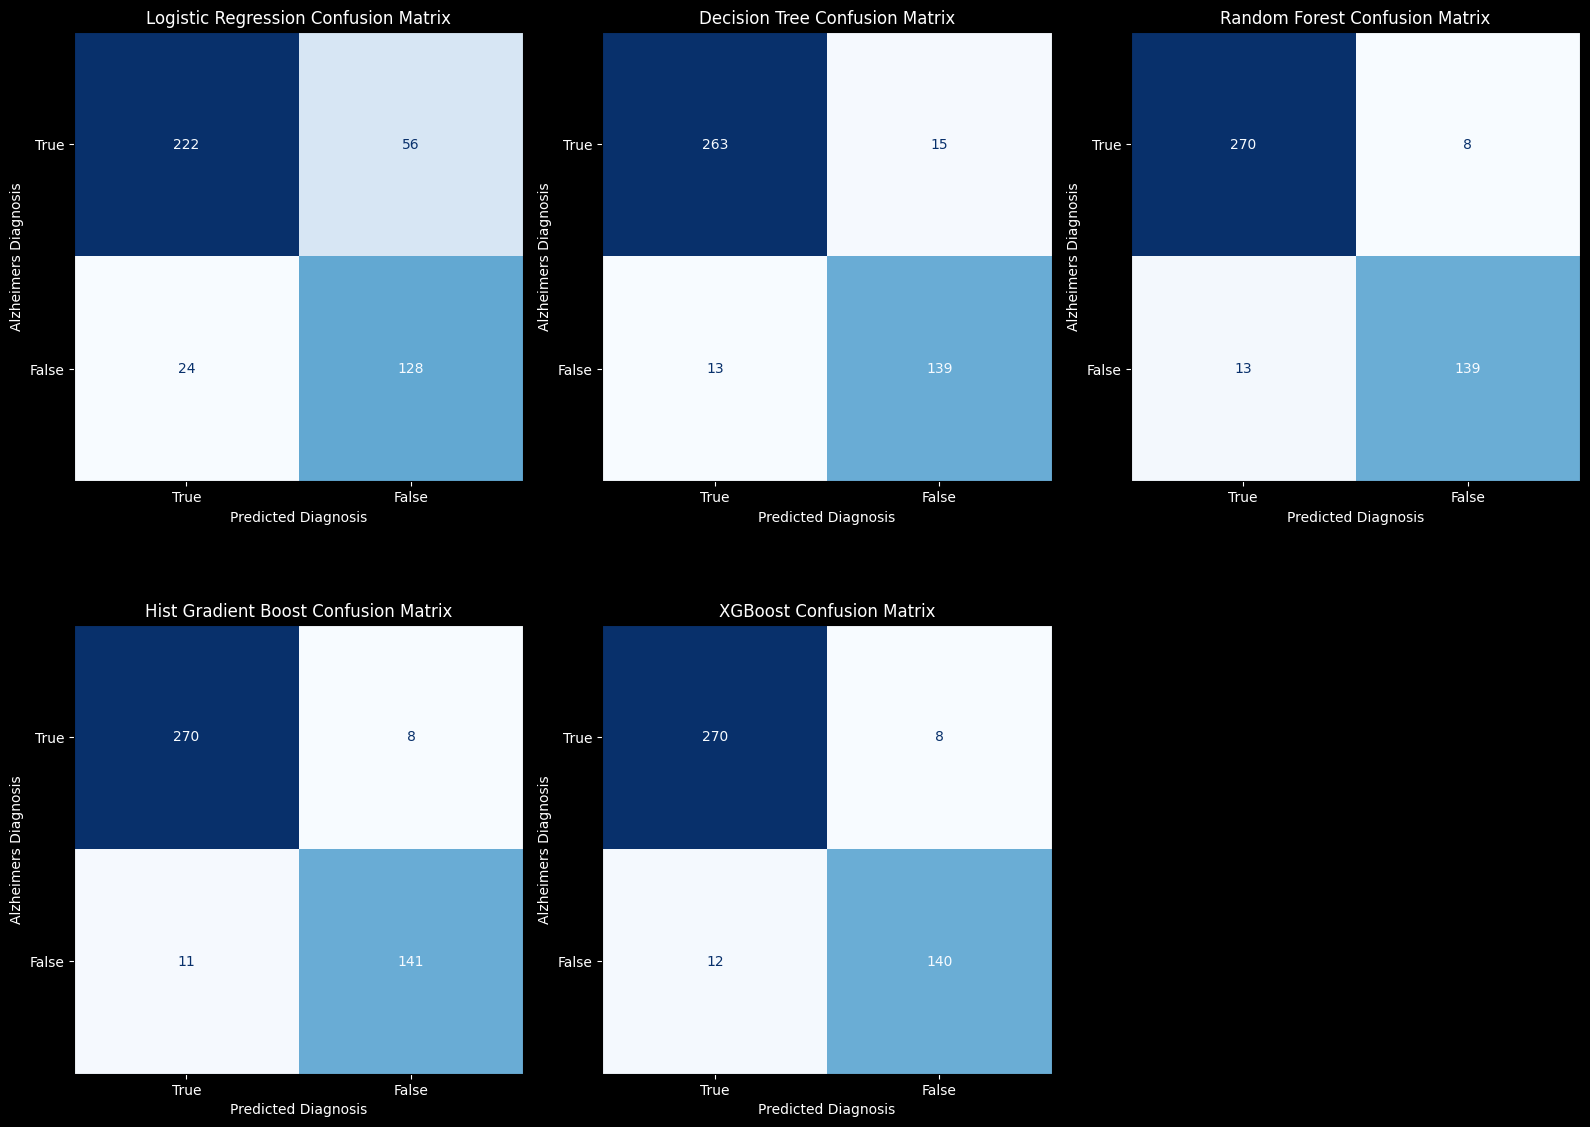

In [ ]:
#Initilizing a matplotlib subplot with a shape of (2, 3)
fig, axes = plt.subplots(2, 3, figsize=(16, 12))

#Loop through each model in results to plot their Confusion Matrix
for model_name, metrics in results.items():
    
    #Using predetermined values to plot position and title the graph
    row, col, title = metrics['plot_pos']
    
    #Gets the predicted labels stored in the results dictionary
    y_pred = metrics['y_pred']
    
    #Compute the confusion matrix using testing data and the predictor of current model
    cm = confusion_matrix(y_test, y_pred)
    
    #Instantiate a ConfusionMatrixDisplay object with lables for display
    disp = ConfusionMatrixDisplay(cm, display_labels=["True", "False"])
    
    #Plot the Confusion Matrix on the specificed subplot axis without a colorbar using the "Blues" colormap
    disp.plot(ax=axes[row][col], colorbar=False, cmap="Blues")
    
    #Setting title and labels of axis
    axes[row][col].set_title(f"{title} Confusion Matrix", color='white')
    axes[row][col].set_ylabel("Alzheimers Diagnosis", color='white')
    axes[row][col].set_xlabel("Predicted Diagnosis", color='white')

    axes[row][col].set_facecolor('black')
    axes[row][col].figure.patch.set_facecolor(color='black')

    axes[row][col].tick_params(axis='x', colors='white')
    axes[row][col].tick_params(axis='y', colors='white')

fig.delaxes(axes[1][2])
plt.tight_layout()
plt.show()

### Classification Reports

In [33]:
for model_name, metrics in results.items():
    metrics['report'] = classification_report(y_test, metrics['y_pred'])
    
for model_name, metrics in results.items():
    print(f"{model_name} Classification Report:")
    print(metrics['report'])
    print('-' * 53)
    
#Logistic Regression Importance Values
'''
coefficients = log.coef_[0]
feat_df = pd.DataFrame({'Feature': X.columns, 'Coefficient': coefficients})
feat_df['AbsCoefficient'] = feat_df['Coefficient'].abs()
feat_df = feat_df.sort_values(by='AbsCoefficient', ascending=True)
plt.figure(figsize=(10, 6))
plt.barh(feat_df['Feature'], feat_df['Coefficient'])
plt.xlabel('Coefficient Value')
plt.title('Feature Coefficients (Logistic Regression)')
plt.show()
'''

LogisticRegression Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.80      0.85       278
           1       0.70      0.84      0.76       152

    accuracy                           0.81       430
   macro avg       0.80      0.82      0.80       430
weighted avg       0.83      0.81      0.82       430

-----------------------------------------------------
DecisionTree Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.95      0.95       278
           1       0.90      0.91      0.91       152

    accuracy                           0.93       430
   macro avg       0.93      0.93      0.93       430
weighted avg       0.94      0.93      0.93       430

-----------------------------------------------------
RandomForest Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.97      0.96       278
           1   

"\ncoefficients = log.coef_[0]\nfeat_df = pd.DataFrame({'Feature': X.columns, 'Coefficient': coefficients})\nfeat_df['AbsCoefficient'] = feat_df['Coefficient'].abs()\nfeat_df = feat_df.sort_values(by='AbsCoefficient', ascending=True)\nplt.figure(figsize=(10, 6))\nplt.barh(feat_df['Feature'], feat_df['Coefficient'])\nplt.xlabel('Coefficient Value')\nplt.title('Feature Coefficients (Logistic Regression)')\nplt.show()\n"

### Receiver Operating Characteristic Curves

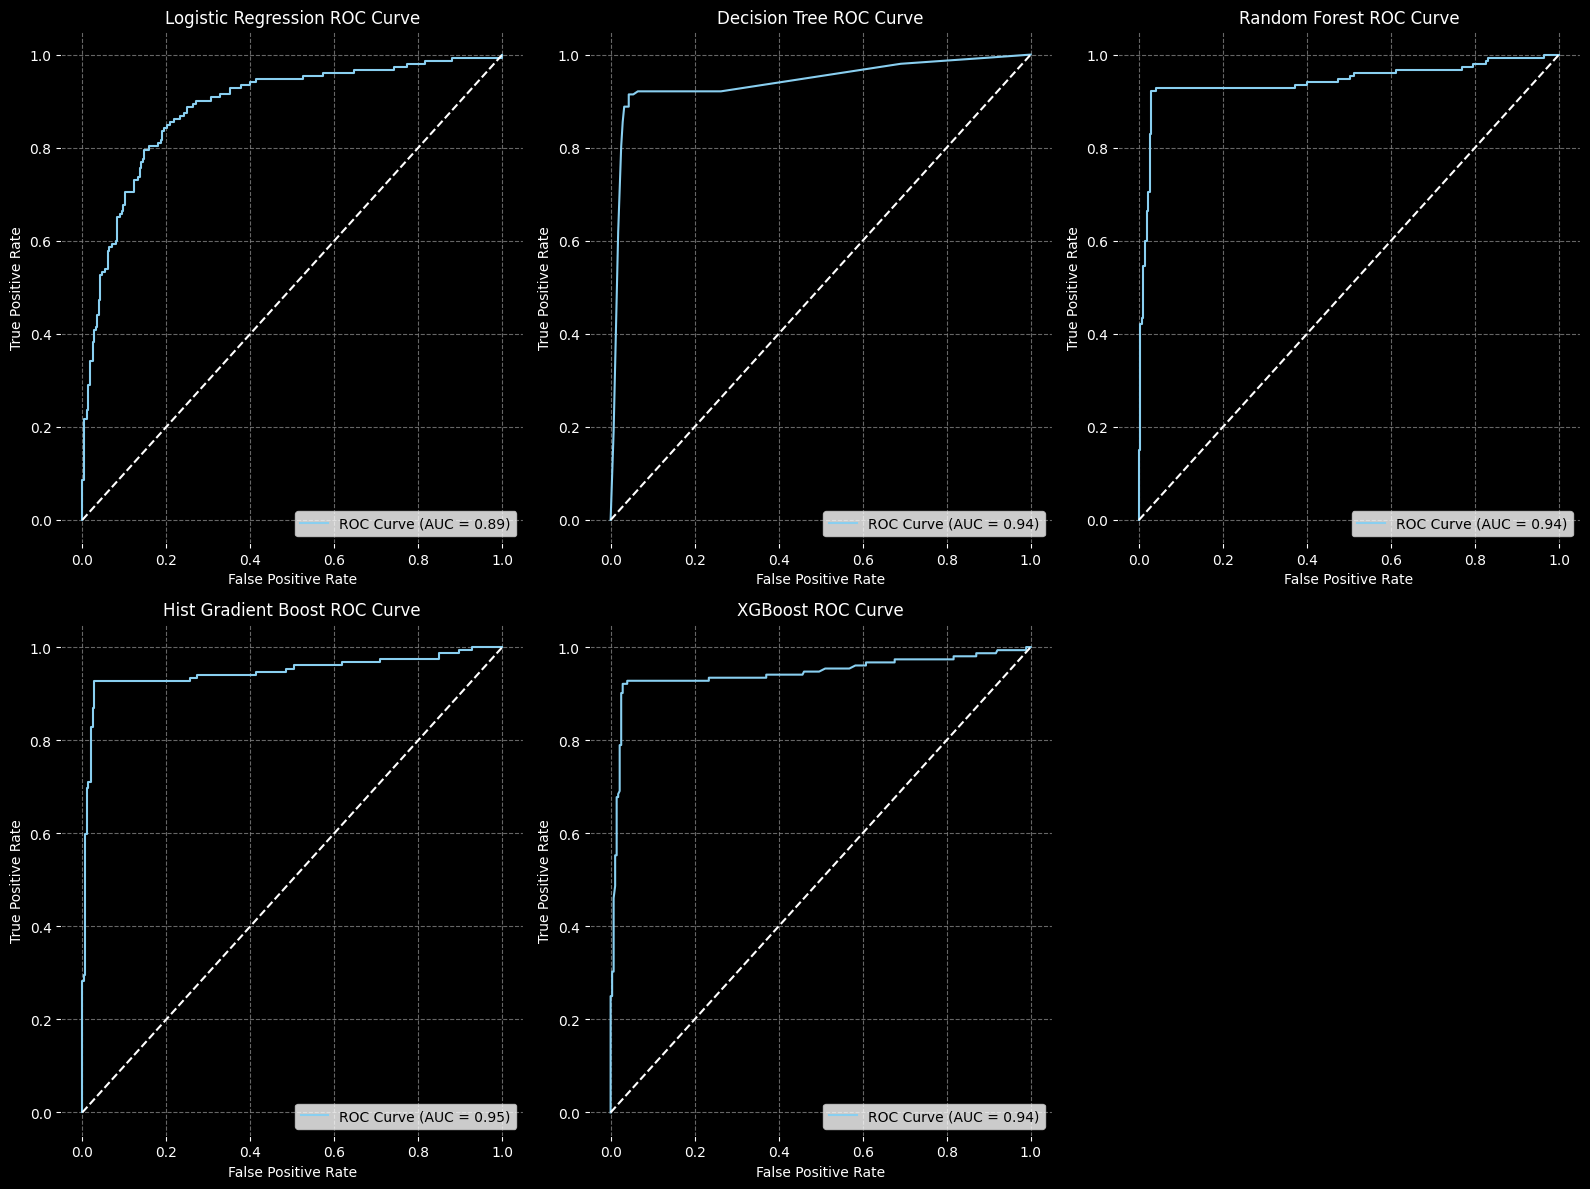

In [34]:
fig, axes = plt.subplots(2, 3, figsize=(16, 12))
for model_name, metrics in results.items():
    row, col, title = metrics['plot_pos']
    y_prob = metrics['y_prob_class1']
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = roc_auc_score(y_test, y_prob)
    axes[row][col].plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})', color='#89CFF0')
    axes[row][col].plot([0, 1], [0, 1], color='white', linestyle='--')
    axes[row][col].set_xlabel('False Positive Rate', color='white')
    axes[row][col].set_ylabel('True Positive Rate', color='white')
    axes[row][col].set_title(f'{title} ROC Curve', color='white')
    axes[row][col].legend(loc="lower right")

    axes[row][col].grid(True, linestyle='--', alpha=0.8, color='grey')

    axes[row][col].set_facecolor('black')
    axes[row][col].figure.patch.set_facecolor(color='black')

    axes[row][col].tick_params(axis='x', colors='white')
    axes[row][col].tick_params(axis='y', colors='white')

fig.delaxes(axes[1][2])

plt.tight_layout()
plt.show()

## Best Model!

In [35]:
best_model = None
best_model_accuracy = -1

for model_name in results:
    if(results[model_name]["k-fold"] > best_model_accuracy):
        best_model = model_name
        best_model_accuracy = results[model_name]["k-fold"]
msgt = f'The best model after K-Fold Cross Validation 5, is {best_model} with an accuracy of {best_model_accuracy:.2f}%'
hw = len(msgt)
msgb = f'------Model Accuracy Rankings------'
print(f"{msgt}\n{msgb.center(hw)}")
ranks = []
for model_name in results:
    ranks.append((model_name, results[model_name]["k-fold"]))
for i in range(1, len(ranks)):
    j=i
    while j>0 and ranks[j][1] > ranks[j-1][1]:
        ranks[j], ranks[j-1] = ranks[j-1], ranks[j]
        j-=1
max_len = 0
for things in ranks:
    if(len(things[0]) > max_len):
        max_len = len(things[0])
for rank in ranks:
    msg = (f"{rank[0]:<{max_len}}|| {f'{rank[1]:.2f}%':>14}")
    print(msg.center(hw))
filler = ''
for i in range(len(msgb)):
    filler+="-"
print(filler.center(hw))

The best model after K-Fold Cross Validation 5, is XGBoost with an accuracy of 95.49%
                         ------Model Accuracy Rankings------                         
                         XGBoost           ||         95.49%                         
                         HistGradientBoost ||         95.11%                         
                         RandomForest      ||         95.07%                         
                         DecisionTree      ||         94.83%                         
                         LogisticRegression||         82.13%                         
                         -----------------------------------                         


## Unsupervised Learning

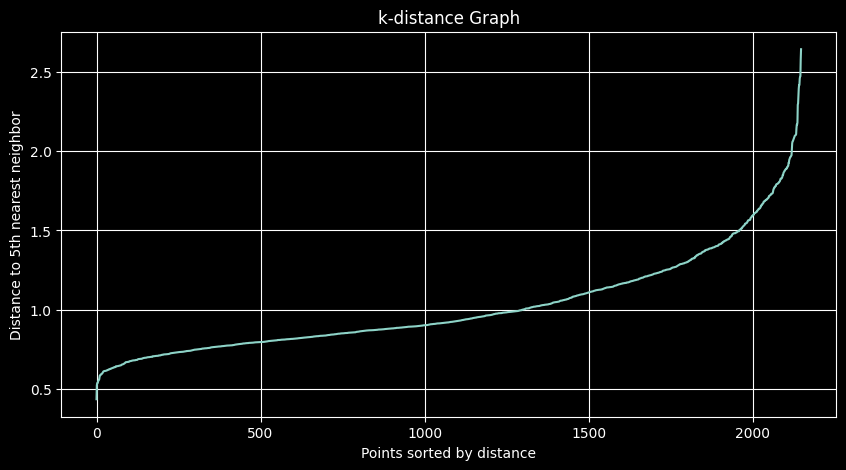

Estimated number of clusters: 2
Number of noise points: 0


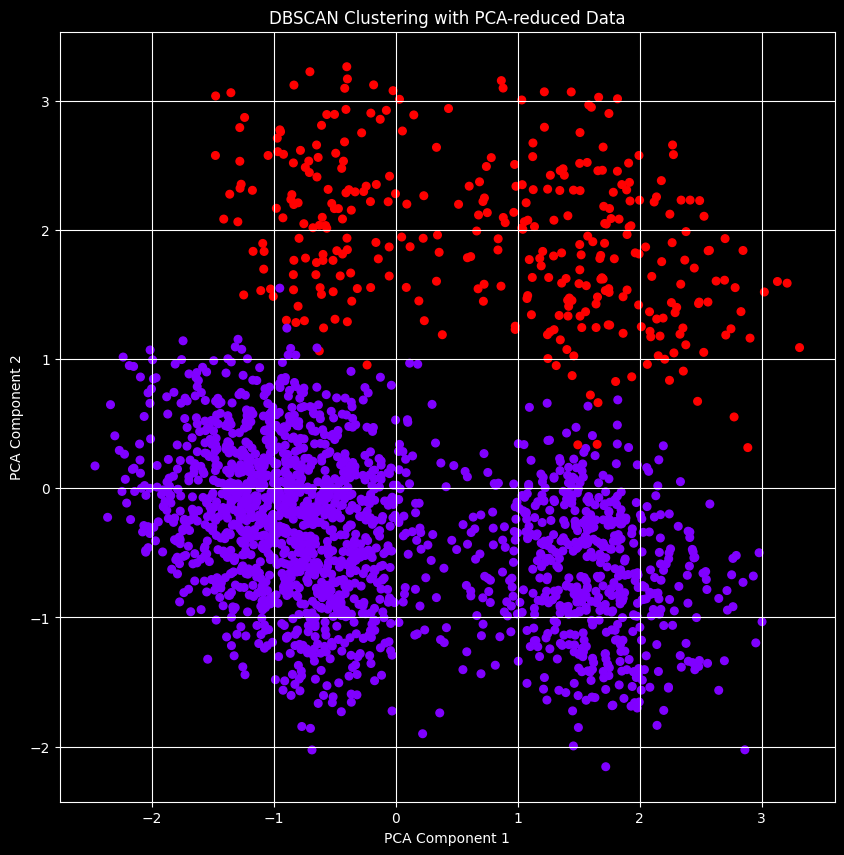

The average silhouette score is: 0.43480780298258487
Cumulative variance explained by 2 principal components: 34.38%


            Age       BMI      MMSE  FunctionalAssessment  MemoryComplaints  \
PC_1  0.029244  0.074507  0.243193              0.411251          0.323696   
PC_2  0.130042  0.366697  0.251736              0.078399          0.087178   

      BehavioralProblems       ADL  Diagnosis  
PC_1            0.205992  0.372923   0.692127  
PC_2            0.789741  0.384343   0.009714  


'------------- K-Means Clustering ---------\nkmeans = KMeans(n_clusters=5,random_state=2028,n_init=\'auto\') # 93.02 = 2028\nkmeans.fit(X)\nresults[\'KMeans\'] = {\'model\':kmeans,\n                           \'labels\':kmeans.labels_,\n                           \'centroids\':kmeans.cluster_centers_,\n                           \'y\':kmeans.predict(X)}\n\n\n######## K-Means Clustering: Finding K ########\n# Elbow method to choose K\nX_K = X.drop(columns=[\'EducationLevel\',\'Smoking\',\'HeadInjury\',\'Hypertension\',\'MemoryComplaints\',\'BehavioralProblems\',\'Confusion\',\'Disorientation\',\'PersonalityChanges\',\'DifficultyCompletingTasks\',\'Forgetfulness\',\'Gender_1\',\'Ethnicity_1\',\'Ethnicity_2\',\'Ethnicity_3\',\'FamilyHistoryAlzheimers_1\']) # removed binary/ordinal data\nscaler = StandardScaler()\nX_K_scaled = scaler.fit_transform(X_K)\n\ninertia = []\nrangeOfK = (1,13+1)\nfor k in range(rangeOfK[0],rangeOfK[1]):\n    km = KMeans(n_clusters=k, random_state=SEED)\n    km.fi

In [23]:
k = 5

nearest_neighbors = NearestNeighbors(n_neighbors=k)
neighbors = nearest_neighbors.fit(X_scaled)
distances, indices = neighbors.kneighbors(X_scaled)
distances = np.sort(distances[:, k - 1], axis=0)
plt.figure(figsize=(10, 5))
plt.plot(distances)
plt.title('k-distance Graph')
plt.ylabel(f'Distance to {k}th nearest neighbor')
plt.xlabel('Points sorted by distance')
plt.grid(True)
plt.show()

db = DBSCAN(eps=2.6, min_samples=k)
df = usableCSV[['Age', 'BMI', 'MMSE', 'FunctionalAssessment', 'MemoryComplaints','BehavioralProblems', 'ADL', 'Diagnosis']]
X_scaled = StandardScaler().fit_transform(df)
db_labels = db.fit_predict(X_scaled)
labels = db_labels
pca_2 = PCA(n_components=2)
data_pca = pca_2.fit_transform(X_scaled)
unique_labels = set(labels)
n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
n_noise = list(labels).count(-1)

print(f'Estimated number of clusters: {n_clusters}')
print(f'Number of noise points: {n_noise}')
plt.figure(figsize=(10, 10))
plt.scatter(data_pca[:, 0], data_pca[:, 1], c=db_labels, cmap='rainbow', s=30)

plt.title('DBSCAN Clustering with PCA-reduced Data')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.grid(True)
plt.show()


if len(set(labels)) > 1 and len(labels[labels != -1]) > 1:
    silhouette_avg = silhouette_score(data_pca, labels)
    print(f"The average silhouette score is: {silhouette_avg}")
else:
    print("DBSCAN did not find enough clusters (or only noise) to calculate silhouette score.")

print('Cumulative variance explained by 2 principal components: {:.2%}'.format(np.sum(pca_2.explained_variance_ratio_)))
dataset_pca = pd.DataFrame(abs(pca_2.components_), columns=df.columns, index=['PC_1', 'PC_2'])
print('\n\n', dataset_pca)


"""df = usableCSV[['Age', 'EducationLevel', 'BMI', 'AlcoholConsumption', 'PhysicalActivity', 'DietQuality', 'SleepQuality', 'CholesterolTotal', 'CholesterolLDL', 'CholesterolHDL', 'CholesterolTriglycerides', 'MMSE', 'FunctionalAssessment', 'MemoryComplaints', 'BehavioralProblems', 'ADL']]
X_scaled = StandardScaler().fit_transform(df)



pca = PCA(n_components=2)
data_ss = pca.fit_transform(X_scaled)
kmeans = KMeans(n_clusters=4)
y_kmeans = kmeans.fit_predict(data_ss)
kmeans.cluster_centers_
centroids = kmeans.cluster_centers_
plt.figure(figsize=(10,10))
plt.title("PCA & KMeans")
plt.scatter(data_ss[:,0], data_ss[:,1], c = y_kmeans, cmap='rainbow')
plt.scatter(centroids[:, 0], centroids[:, 1], c='black', s=50)
plt.show()
from sklearn.cluster import AgglomerativeClustering
hclust = AgglomerativeClustering(n_clusters=2, metric='euclidean', linkage='ward')
golfers_hclust_labels = hclust.fit(data_ss).labels_
plt.figure(figsize=(10,10))
plt.title("PCA & Agglomerative Clustering")
plt.scatter(data_ss[:,0], data_ss[:,1], c = golfers_hclust_labels, cmap='rainbow')
plt.show()"""

#### Spencer's Unsupervised 

'''------------- K-Means Clustering ---------
kmeans = KMeans(n_clusters=5,random_state=2028,n_init='auto') # 93.02 = 2028
kmeans.fit(X)
results['KMeans'] = {'model':kmeans,
                           'labels':kmeans.labels_,
                           'centroids':kmeans.cluster_centers_,
                           'y':kmeans.predict(X)}


######## K-Means Clustering: Finding K ########
# Elbow method to choose K
X_K = X.drop(columns=['EducationLevel','Smoking','HeadInjury','Hypertension','MemoryComplaints','BehavioralProblems','Confusion','Disorientation','PersonalityChanges','DifficultyCompletingTasks','Forgetfulness','Gender_1','Ethnicity_1','Ethnicity_2','Ethnicity_3','FamilyHistoryAlzheimers_1']) # removed binary/ordinal data
scaler = StandardScaler()
X_K_scaled = scaler.fit_transform(X_K)

inertia = []
rangeOfK = (1,13+1)
for k in range(rangeOfK[0],rangeOfK[1]):
    km = KMeans(n_clusters=k, random_state=SEED)
    km.fit(X_K_scaled)
    inertia.append(km.inertia_)

plt.plot(range(rangeOfK[0],rangeOfK[1]), inertia, marker='o')
plt.xlabel('K clusters')
plt.ylabel('Inertia')
plt.title("Elbow Method for Alzheimer's Data")
plt.show()

chosenK = 1

kmeans = KMeans(n_clusters=chosenK, random_state=SEED)
clusters = kmeans.fit_predict(X_K_scaled)
X_K['cluster'] = clusters

# Analyze clusters
print(X_K.groupby('cluster').mean())

######## K-Means Cluster ########
X_vis = X_K.copy()
X_vis['cluster'] = clusters

display(X_vis)
# 2D visualization with pairplot
sns.pairplot(X_vis, hue='cluster', palette='Set2', corner=True)
plt.suptitle('K-Means Clusters', y=1.02)
plt.show()
'''

In [37]:
def generate_age_risk(
    sample: pd.DataFrame,
    metrics_to_improve: list = ["FunctionalAssessment"],
    improvement_rate: float = 1.0,
    max_values: dict = None,
    min_values: dict = None,
    custom_directions: dict = None
) -> pd.DataFrame:
    default_bounds = {
        "FunctionalAssessment": {"max": 10, "min": 0, "default_dir": "increase"},
        "PhysicalActivity": {"max": 10, "min": 0, "default_dir": "increase"},
        "DietQuality": {"max": 10, "min": 0, "default_dir": "increase"},
        "SleepQuality": {"max": 10, "min": 0, "default_dir": "increase"},
        "BMI": {"max": 40, "min": 18.5, "default_dir": "decrease"},
        "AlcoholConsumption": {"max": 20, "min": 0, "default_dir": "decrease"}
    }

    max_values = max_values or {}
    min_values = min_values or {}
    custom_directions = custom_directions or {}

    original_age = sample["Age"].iloc[0]
    start_age = max(0, original_age - 10)
    ages = np.arange(start_age, 101, 1)
    result_rows = []

    for age in ages:
        new_row = sample.copy()
        new_row["Age"] = age
        
        if age > original_age:
            for metric in metrics_to_improve:
                if metric in new_row.columns:
                    original_value = sample[metric].iloc[0]
                    years_passed = age - original_age
                    
                    direction = custom_directions.get(metric)
                    if direction is None and metric in default_bounds:
                        direction = default_bounds[metric]["default_dir"]
                    
                    bounds = default_bounds.get(metric, {})
                    max_val = max_values.get(metric, bounds.get("max"))
                    min_val = min_values.get(metric, bounds.get("min"))
                    
                    if direction == "increase":
                        new_value = original_value + years_passed * improvement_rate
                        if max_val is not None:
                            new_value = min(new_value, max_val)
                    elif direction == "decrease":
                        new_value = original_value - years_passed * improvement_rate
                        if min_val is not None:
                            new_value = max(new_value, min_val)
                    else:
                        new_value = original_value
                    
                    new_row[metric] = new_value
        
        result_rows.append(new_row)

    return pd.concat(result_rows, ignore_index=True)

def create_ultra_smooth_animation(model_name, age_variants_df, scaler, sample_df,
                                  animation_speed=0.2, exponential_factor=3.0,
                                  metrics_to_improve: list = ["FunctionalAssessment"]):
    
    age_variants_df = pd.DataFrame(age_variants_df, columns=X.columns)
    age_variants_df = age_variants_df[age_variants_df["Age"] <= 100]
    model = results[model_name]['model']
    output_gif = f'Gif/best_risk_animation_{model_name}.gif'
    
    X_pred_scaled = scaler.transform(age_variants_df)
    
    risk_percent = model.predict_proba(X_pred_scaled)[:, 1] * 100
    risk_percent = np.clip(risk_percent, 0, 100)
    
    ages = age_variants_df["Age"].values

    X_orig_scaled = scaler.transform(sample_df)
    orig_risk = model.predict_proba(X_orig_scaled)[:, 1][0] * 100
    orig_risk = np.clip(orig_risk, 0, 100)
    original_age = sample_df["Age"].iloc[0]

    window_size = min(15, len(ages) - 1)
    if window_size % 2 == 0:
        window_size -= 1
    smoothed_risk = savgol_filter(risk_percent, window_size, 3) if window_size > 1 else risk_percent

    ages_hires = np.linspace(ages.min(), 100, 200)
    smoothed_risk_hires = interp1d(ages, smoothed_risk, kind='cubic', fill_value="extrapolate")(ages_hires)

    title_string = ", ".join(metrics_to_improve)

    risk_improvement = (orig_risk - smoothed_risk_hires) / orig_risk * 100
    risk_improvement = np.clip(risk_improvement, -100, 100)

    fig, ax = plt.subplots(figsize=(12, 7))
    ax.set_xlim(ages.min(), 100)
    ax.set_ylim(0, 100)
    ax.set_title(f"NeuroCurve's Alzheimer's Risk ({model_name})", fontsize=14, color='white')
    ax.set_xlabel(title_string + " improvements over time (Age)", fontsize=12, color='white')
    ax.set_ylabel("Risk Probability (%)", fontsize=12, color='white')
    ax.grid(True, linestyle='--', alpha=0.8, color='grey')
    ax.set_facecolor('black')
    ax.figure.patch.set_facecolor('black')

    ax.tick_params(axis='x', colors='white')
    ax.tick_params(axis='y', colors='white')

    for spine in ax.spines.values():
        spine.set_linewidth(2.5)
        spine.set_color('white')

    line, = ax.plot([], [], color='#90EE90', linewidth=7)
    moving_point = ax.scatter([], [], color='#90EE90', s=100, zorder=10)
    original_point = ax.scatter(original_age, orig_risk, color='blue', s=150, 
                                zorder=15, label=f'Current Risk (Age {original_age:.0f}: {orig_risk:.1f}%)')
    ax.legend(loc='lower left')

    info_text = ax.text(0.02, 0.95, '', transform=ax.transAxes, 
                        fontsize=12, ha='left', va='top',
                        bbox=dict(facecolor='grey', alpha=0.9))
    
    improvement_text = ax.text(0.02, 0.5, '', transform=ax.transAxes,
                               fontsize=14, ha='left', va='center', weight='bold',
                               bbox=dict(facecolor='grey', alpha=0.9, linewidth=2))

    total_frames = int(len(ages_hires) * animation_speed)
    t = np.linspace(0, 1, total_frames)
    exp_t = (np.exp(exponential_factor * t) - 1) / (np.exp(exponential_factor) - 1)
    frame_indices = (exp_t * (len(ages_hires) - 1)).astype(int)

    delay_frames = int(3 * 15)

    def update(frame):
        if frame < total_frames:
            idx = frame_indices[frame]
            current_risk = smoothed_risk_hires[idx]
            current_improvement = risk_improvement[idx]
            
            line.set_data(ages_hires[:idx+1], smoothed_risk_hires[:idx+1])
            moving_point.set_offsets([[ages_hires[idx], current_risk]])
            
            info_text.set_text(f'Projected Age: {ages_hires[idx]:.1f}\nRisk: {current_risk:.1f}%')
            
            improvement_color = '#2ECC71' if current_improvement > 0 else '#E74C3C'
            improvement_text.set_text(f'Risk Improvement:\n{current_improvement:.1f}%')
            improvement_text.set_color(improvement_color)
                
        return line, moving_point, original_point, info_text, improvement_text

    ani = FuncAnimation(fig, update, frames=total_frames + delay_frames,
                        interval=int(150 / animation_speed), blit=True, repeat=True)
    os.chdir('..')
    
    ani.save(output_gif, writer='pillow', fps=15, dpi=100)
    os.chdir('NeuroPy')
    plt.close()

    return HTML(f'<img src="{output_gif}">')
sample_df = X.iloc[[13]]

patient_age_risk = generate_age_risk(sample_df, ['FunctionalAssessment'])

create_ultra_smooth_animation(
    str(best_model),
    patient_age_risk,
    scaler,
    sample_df,
    metrics_to_improve=['FunctionalAssessment']
)